In [1]:
from data_loader import *
from evaluate_captions import *
import csv
from build_vocab import *
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
from model import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
train_json = './data/annotations/captions_train2014.json'
test_json = './data/annotations/captions_val2014.json'
train_root = './data/images/train/'
test_root = './data/images/test/'
vocab = build_vocab(train_json)
with open('TrainImageIds.csv', 'r') as f:
    reader = csv.reader(f)
    trainIds = list(reader)
trainIds = [int(i) for i in trainIds[0]]
#train_dataset = CocoDataset(train_root, train_json, trainIds, vocab)

valIds = trainIds[-len(trainIds)//5:]
trainIds = trainIds[:-len(trainIds)//5]

with open('TestImageIds.csv', 'r') as f:
    reader = csv.reader(f)
    testIds = list(reader)
testIds = [int(i) for i in testIds[0]]
#test_dataset = CocoDataset(test_root, test_json, testIds, vocab)

loading annotations into memory...
Done (t=0.77s)
creating index...


  0%|          | 604/414113 [00:00<01:08, 6037.30it/s]

index created!


100%|██████████| 414113/414113 [01:05<00:00, 6328.81it/s]


In [16]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

tsfm = transforms.Compose([
        transforms.Resize(size=(300,300)),
        transforms.ToTensor(),
        normalize,
    ])
train_loader = get_loader(train_root, train_json, trainIds, vocab, 
                          transform=tsfm, 
                          batch_size=50, 
                          shuffle=True, 
                          num_workers=4)
val_loader = get_loader(train_root, train_json, valIds, vocab, 
                          transform=tsfm, 
                          batch_size=50, 
                          shuffle=True, 
                          num_workers=4)
test_loader = get_loader(test_root, test_json, testIds, vocab, 
                          transform=tsfm, 
                          batch_size=10, 
                          shuffle=True, 
                          num_workers=4)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [4]:
#pretrained word embedding
#!curl  -L http://nlp.stanford.edu/data/glove.6B.zip>glove.6B.zip
#!unzip glove.6B.zip
pretrain_embed = False
if pretrain_embed:
    word2vec = {}
    idx = 0
    with open("glove.6B.300d.txt","rb") as f:
        for l in tqdm(f.readlines()):
            line = l.decode().split()
            word2vec[line[0]] = [float(x) for x in line[1:]]
            idx+=1
    pretrained_weight = np.zeros((vocab.idx, 300))
    for i in range(vocab.idx):
        word = vocab[i]
        if word in word2vec:
            pretrained_weight[i] = word2vec[word]
        else:
            pretrained_weight[i] = np.random.randn(300)

In [5]:
embed_dim = 300
vocab_size= vocab.idx
hiddem_dim = 512


baseline = Img_Caption(encoder= res50_encoder(embed_dim), rnn=nn.LSTM, 
                        vocab_size=vocab_size, 
                        embed_dim=embed_dim,
                        hidden_dim=hiddem_dim,
                        embed_weight = torch.tensor(pretrained_weight) if pretrain_embed else None
                      )

optimizer = optim.Adam(baseline.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [6]:

use_gpu = torch.cuda.is_available()
if use_gpu:
    baseline = baseline.cuda()


def train(mod, epochs):
    mod.train()
    best_loss = float('inf')
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        losss = []
        ts = time.time()
        for i, (imgs, caps, lengths) in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                imgs = imgs.cuda()# Move your inputs onto the gpu
                caps = caps.cuda()# Move your labels onto the gpu
                #lengths = lengths.cuda()
            
            outputs = mod(imgs, caps, lengths)
            targets = nn.utils.rnn.pack_padded_sequence(caps, lengths, batch_first=True)[0]
            loss = criterion(outputs, targets)
            losss.append(loss.item())
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, i, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        # torch.save(fcn_model, 'best_model')
        
        train_loss.append(np.mean(losss))
        epoch_loss = val(mod)
        val_loss.append(epoch_loss)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(mod, 'best_model')
        mod.train()
    return train_loss,val_loss
def val(mod):
    mod.eval()
    
    ts = time.time()
    val_loss = 0
    for i, (imgs, caps, lengths) in enumerate(val_loader):
        optimizer.zero_grad()
        
        if use_gpu:
            imgs = imgs.cuda()# Move your inputs onto the gpu
            caps = caps.cuda()# Move your labels onto the gpu
            #lengths = lengths.cuda()

        outputs = mod(imgs, caps, lengths)
        targets = nn.utils.rnn.pack_padded_sequence(caps, lengths, batch_first=True)[0]
        loss = criterion(outputs, targets)
        val_loss += loss.item()
        
        if i % 100 == 0:
            print("iter{}, loss: {}".format(i, loss.item()))
    val_loss/=len(val_loader)
    print('validation loss:', val_loss)
    print("Finish validation time elapsed {}".format(time.time() - ts))
    return val_loss

In [7]:
epochs  = 20
train_loss, val_loss = train(baseline, epochs)

epoch0, iter0, loss: 10.130311965942383
epoch0, iter100, loss: 4.014859676361084
epoch0, iter200, loss: 3.560607671737671
epoch0, iter300, loss: 3.490773916244507
epoch0, iter400, loss: 3.408262014389038
epoch0, iter500, loss: 3.325308084487915
epoch0, iter600, loss: 3.2753801345825195
epoch0, iter700, loss: 3.1713428497314453
epoch0, iter800, loss: 2.9207377433776855
epoch0, iter900, loss: 3.1874606609344482
epoch0, iter1000, loss: 3.2764930725097656
epoch0, iter1100, loss: 3.036099672317505
epoch0, iter1200, loss: 2.9958560466766357
epoch0, iter1300, loss: 2.9283697605133057
Finish epoch 0, time elapsed 236.15938305854797
iter0, loss: 3.0030698776245117
iter100, loss: 3.080371379852295
iter200, loss: 2.8455560207366943
iter300, loss: 2.812453508377075
validation loss: 2.916932142642607
Finish validation time elapsed 61.047523498535156


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Img_Caption. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3

epoch1, iter0, loss: 2.5475456714630127
epoch1, iter100, loss: 2.7789053916931152
epoch1, iter200, loss: 2.5495171546936035
epoch1, iter300, loss: 2.764979124069214
epoch1, iter400, loss: 2.873788833618164
epoch1, iter500, loss: 2.5419955253601074
epoch1, iter600, loss: 2.8555636405944824
epoch1, iter700, loss: 2.7728629112243652
epoch1, iter800, loss: 2.409437656402588
epoch1, iter900, loss: 2.572618007659912
epoch1, iter1000, loss: 2.8724899291992188
epoch1, iter1100, loss: 2.7364134788513184
epoch1, iter1200, loss: 2.8981401920318604
epoch1, iter1300, loss: 2.653214454650879
Finish epoch 1, time elapsed 241.2845757007599
iter0, loss: 2.6104214191436768
iter100, loss: 2.54329252243042
iter200, loss: 2.6458828449249268
iter300, loss: 2.8065383434295654
validation loss: 2.6706660375537643
Finish validation time elapsed 60.04452562332153
epoch2, iter0, loss: 2.453793525695801
epoch2, iter100, loss: 2.2764360904693604
epoch2, iter200, loss: 2.485788106918335
epoch2, iter300, loss: 2.5561

Finish epoch 10, time elapsed 256.98368859291077
iter0, loss: 2.50836443901062
iter100, loss: 2.2728538513183594
iter200, loss: 2.310086727142334
iter300, loss: 2.473691701889038
validation loss: 2.4498613419302977
Finish validation time elapsed 66.97195529937744
epoch11, iter0, loss: 1.8036317825317383
epoch11, iter100, loss: 1.7329550981521606
epoch11, iter200, loss: 1.8780702352523804
epoch11, iter300, loss: 1.8397103548049927
epoch11, iter400, loss: 1.8848369121551514
epoch11, iter500, loss: 2.0606188774108887
epoch11, iter600, loss: 1.861642837524414
epoch11, iter700, loss: 1.9104866981506348
epoch11, iter800, loss: 1.8545385599136353
epoch11, iter900, loss: 1.8147387504577637
epoch11, iter1000, loss: 1.7914109230041504
epoch11, iter1100, loss: 1.926758885383606
epoch11, iter1200, loss: 1.772322654724121
epoch11, iter1300, loss: 1.9191911220550537
Finish epoch 11, time elapsed 254.34884572029114
iter0, loss: 2.517897605895996
iter100, loss: 2.373229503631592
iter200, loss: 2.46446

In [7]:
def idxtowords(idxs):
    words = []
    for idx in idxs:
        if idx == 3:
            break
        words.append(vocab[idx])
    return " ".join(words)
def test(mod):
    mod.eval()
    for i, (imgs, caps, lengths) in enumerate(test_loader):
    
        if use_gpu:
            imgs = imgs.cuda()# Move your inputs onto the gpu
            caps = caps.cuda()# Move your labels onto the gpu
            #lengths = lengths.cuda()
            
        feature = mod.encoder(imgs)
        sampled_ids = mod.sample(feature,max_length = 20)
        
         
#         sampled_ids = sampled_ids[0].cpu().numpy()
        
#         sampled_caption = []
        
#         for word_id in sampled_ids:
#             word = vocab.idx2word[word_id]
#             sampled_caption.append(word)
#             if word == '<end>':
#                 break
                
#         sentence = ' '.join(sampled_caption)
#         print (sentence)
        
#         sampled_caption = []
        
#         for word_id in caps[0].cpu().numpy():
#             word = vocab.idx2word[word_id]
#             sampled_caption.append(word)
#             if word == '<end>':
#                 break
#         sentence = ' '.join(sampled_caption)
#         print(sentence)
#         plt.imshow(np.asarray(imgs[0].cpu().permute(1,2,0)))
        sampled_ids = sampled_ids.cpu().numpy()
        caps = caps.cpu().numpy()
        imgs = np.asarray(imgs.cpu().permute(0,2,3,1))
        for i in range(10):
            generate = idxtowords(sampled_ids[i])
            label = idxtowords(caps[i])
            print('label:',label)
            print('generate:',generate)
            img = imgs[i]
            img-=np.min(img)
            img/=np.max(img)
            plt.imshow(img)
            plt.show()
        break
        
def test(mod):
    mod.eval()
    for i, (imgs, caps, lengths) in enumerate(test_loader):
    
        if use_gpu:
            imgs = imgs.cuda()# Move your inputs onto the gpu
            caps = caps.cuda()# Move your labels onto the gpu
            #lengths = lengths.cuda()
            
        feature = mod.encoder(imgs)
        sampled_ids = mod.Stochastic_sample(feature,max_length = 20,temp = 1)
        
        sampled_ids = sampled_ids.cpu().numpy()
        caps = caps.cpu().numpy()
        imgs = np.asarray(imgs.cpu().permute(0,2,3,1))
        for i in range(10):
            generate = idxtowords(sampled_ids[i])
            label = idxtowords(caps[i])
            print('label:',label)
            print('generate:',generate)
            img = imgs[i]
            img-=np.min(img)
            img/=np.max(img)
            plt.imshow(img)
            plt.show()
        break
        

In [8]:
baseline = torch.load("best_model")

label: <start> an elephant 's front legs are in the water and back legs are out of the water .
generate: <start> a pair of elephants under a deck in nature .


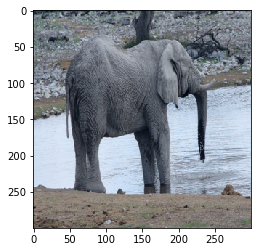

label: <start> a group of sheep in a field with three dogs close by .
generate: <start> a group of cattle and goats stand in three dry grass behind a hill .


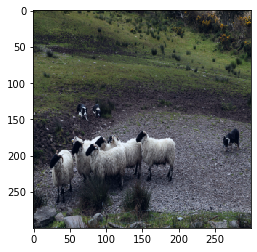

label: <start> an elephant playing with water at a watering hole with his trunk
generate: <start> a dog in a experienced smelling the savannah


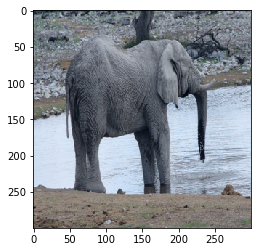

label: <start> an elephant standing with its front feet in the water .
generate: <start> scrabble bird feeding on the tree nearby helpful achievement


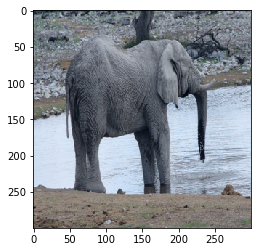

label: <start> an elephant stands with its front feet in shallow water .
generate: <start> an elephant is greeting with two sidewalks sunshines


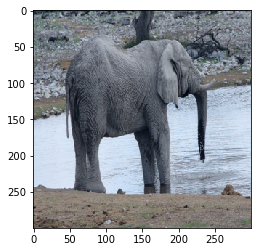

label: <start> three look alike dogs are herding sheep into a pile .
generate: <start> many cows with tusks , tethered in a row , while a crowd watches .


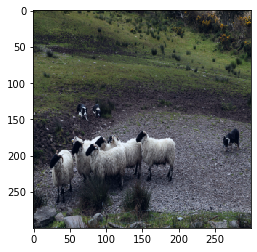

label: <start> small group of sheep being herded by three border collies .
generate: <start> a number of sheep are in the field , and grazing with the pasture on the mark their hills


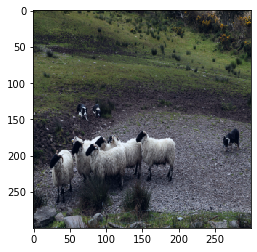

label: <start> an elephant is going to the river to drink water
generate: <start> a lone elephant walks with his trunk during a sunny day .


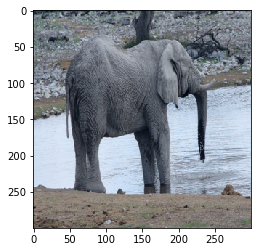

label: <start> these sheep are being watched by three dogs .
generate: <start> animals grazing on grass area with mountains in the background


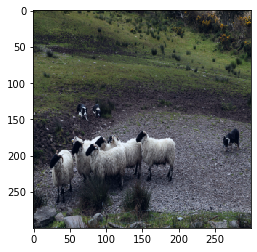

label: <start> a group of sheep surrounded by three dogs .
generate: <start> cows walking in green , clearing , and two white grass in a field with two birds against a


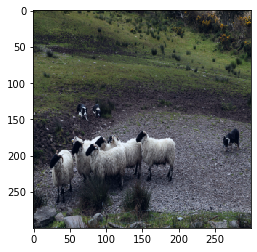

In [15]:

test(baseline)

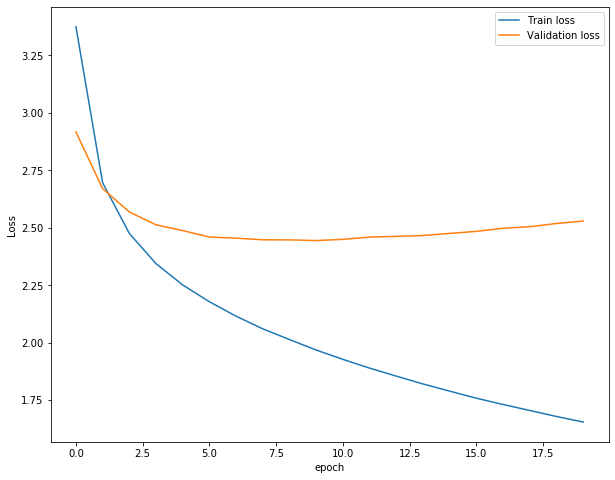

In [14]:
import matplotlib.pyplot as plt
epoch = np.arange(0,20)
plt.figure(figsize = (10,8))
plt.plot(epoch,train_loss,label = "Train loss")
plt.plot(epoch,val_loss,label = "Validation loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
fo = open("log.txt", "w")
fo.write(str(train_loss))
fo.write("\n")
fo.write(str(val_loss))

fo.close()
